/root/miniconda3/envs/myconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data...


/tmp/ipykernel_490/2126921689.py:194: UserWarning: Received a view of an AnnData. Making a copy.
  sc.pp.normalize_total(adata,target_sum=1e4)
/root/miniconda3/envs/myconda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Original start clusters: ['10GMP', '9GMP', '7MEP']
Building MST...
Tracking original lineages...
Merging lineages...
Visualizing results...


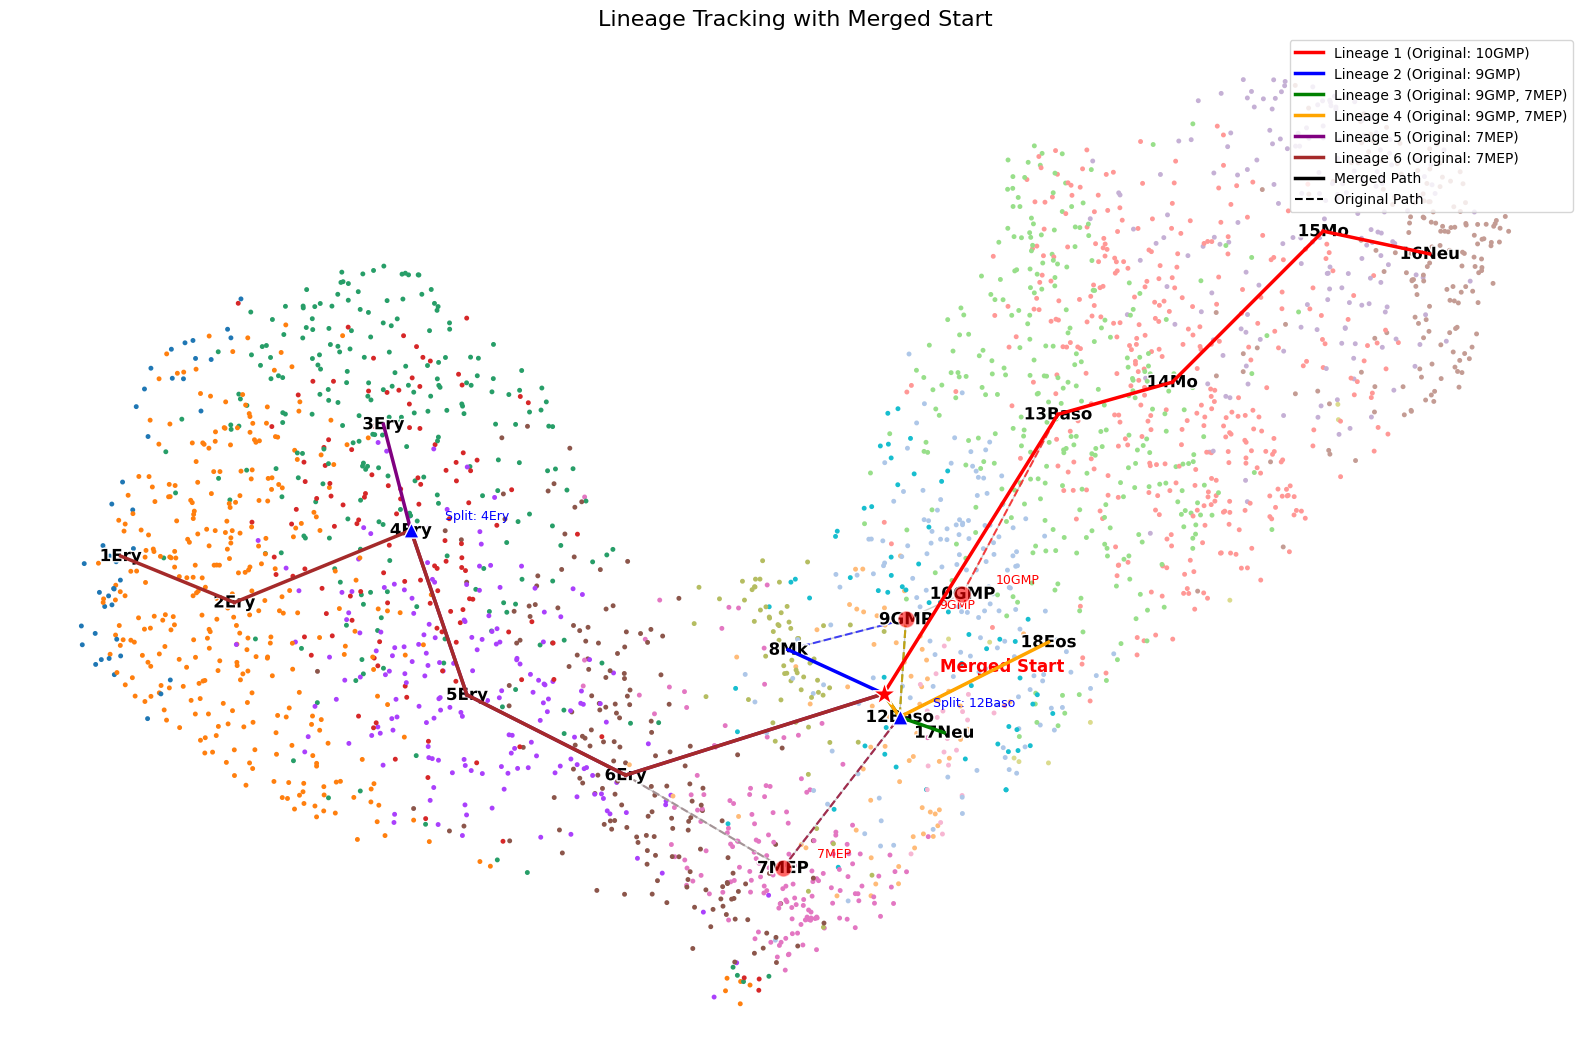

In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import umap

def track_lineages(mst_graph, start_clusters):
    valid_paths = []
    node_coverage = set()
    node_degree = {node: mst_graph.degree(node) for node in mst_graph.nodes}
    
    for start in start_clusters:
        queue = [(start, [start], None)]
        
        while queue:
            current_node, path, parent_node = queue.pop(0)
            neighbors = [n for n in mst_graph.neighbors(current_node) if n != parent_node]
            
            if node_degree[current_node] == 1 and current_node != start:
                valid_paths.append(path.copy())
                node_coverage.update(path)
                continue
            
            for neighbor in neighbors:
                if neighbor in start_clusters and neighbor != start:
                    continue
                new_path = path + [neighbor]
                queue.append((neighbor, new_path, current_node))
    
    all_nodes = set(mst_graph.nodes)
    if node_coverage != all_nodes:
        uncovered = all_nodes - node_coverage
  
    
    lineages = []
    for i, path in enumerate(valid_paths):
        lineage = {
            "id": f"lineage_{i}",
            "start": path[0],
            "path": path,
            "split_points": [node for node in path[1:-1] if node_degree[node] >= 3]
        }
        lineages.append(lineage)
    
    return lineages

def merge_lineage_starts(lineages, start_clusters):
    path_groups = {}
    for lineage in lineages:
        non_start_path = tuple(lineage['path'][1:])
        if non_start_path not in path_groups:
            path_groups[non_start_path] = []
        path_groups[non_start_path].append(lineage)
    
    merged_lineages = []
    for non_start_path, group in path_groups.items():
        starts = [lineage['start'] for lineage in group] 
        merged_lineage = {
            "id": f"merged_lineage_{len(merged_lineages)}",
            "start": "Merged Start",  
            "original_starts": starts, 
            "path": ["Merged Start"] + list(non_start_path),
            "split_points": group[0]['split_points'],
            "original_lineages": [lineage['id'] for lineage in group]
        }
        merged_lineages.append(merged_lineage)
    
    return merged_lineages

def visualize_merged_lineages(adata, mst_edges_df, lineages, merged_lineages, start_clusters, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 12))
    
    umap_coords = adata.obsm['X_umap']
    cluster_labels = adata.obs['paul15_clusters']
    umap_cluster_centers = pd.DataFrame(umap_coords, index=cluster_labels.index).groupby(cluster_labels, observed=True).median()
    
  
    start_centers = umap_cluster_centers.loc[start_clusters]
    merged_center = start_centers.mean()
    merged_x, merged_y = merged_center[0], merged_center[1]

    sc.pl.umap(adata, color='paul15_clusters', ax=ax, show=False, legend_loc='on data',
               size=50, frameon=False, legend_fontsize='large', legend_fontoutline=2)

    for _, row in mst_edges_df.iterrows():
        start, end = row['from'], row['to']
        if start in umap_cluster_centers.index and end in umap_cluster_centers.index:
            x = [umap_cluster_centers.loc[start, 0], umap_cluster_centers.loc[end, 0]]
            y = [umap_cluster_centers.loc[start, 1], umap_cluster_centers.loc[end, 1]]
            ax.plot(x, y, color='#cccccc', linewidth=1.0, zorder=1)
    

    ax.scatter(merged_x, merged_y, s=300, color='red', edgecolor='white', zorder=5, marker='*')
    ax.text(merged_x + 0.5, merged_y + 0.2, 'Merged Start', fontsize=12, fontweight='bold', color='red')
    
    for cluster in start_clusters:
        x, y = umap_cluster_centers.loc[cluster, [0, 1]]
        ax.scatter(x, y, s=150, color='red', alpha=0.6, edgecolor='white', zorder=4, marker='o')
        ax.text(x + 0.3, y + 0.1, cluster, fontsize=9, color='red')
    

    lineage_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 
                     'pink', 'gray', 'olive', 'cyan', 'teal', 'maroon']
    

    for i, merged_lineage in enumerate(merged_lineages):
        color_idx = i % len(lineage_colors)
        path = merged_lineage['path']

        if len(path) >= 2:
            first_node = path[1]
            if first_node in umap_cluster_centers.index:
                x = [merged_x, umap_cluster_centers.loc[first_node, 0]]
                y = [merged_y, umap_cluster_centers.loc[first_node, 1]]
                ax.plot(x, y, color=lineage_colors[color_idx], linewidth=2.5, zorder=3)

        for j in range(1, len(path) - 1):
            start_node = path[j]
            end_node = path[j+1]
            if start_node in umap_cluster_centers.index and end_node in umap_cluster_centers.index:
                x = [umap_cluster_centers.loc[start_node, 0], umap_cluster_centers.loc[end_node, 0]]
                y = [umap_cluster_centers.loc[start_node, 1], umap_cluster_centers.loc[end_node, 1]]
                ax.plot(x, y, color=lineage_colors[color_idx], linewidth=2.5, zorder=3)

    for i, lineage in enumerate(lineages):
        color_idx = i % len(lineage_colors)
        path = lineage['path']
        for j in range(len(path) - 1):
            start_node = path[j]
            end_node = path[j+1]
            if start_node in umap_cluster_centers.index and end_node in umap_cluster_centers.index:
                x = [umap_cluster_centers.loc[start_node, 0], umap_cluster_centers.loc[end_node, 0]]
                y = [umap_cluster_centers.loc[start_node, 1], umap_cluster_centers.loc[end_node, 1]]
                ax.plot(x, y, color=lineage_colors[color_idx], linewidth=1.5, zorder=2, linestyle='--', alpha=0.7)
    

    split_points = set()
    for lineage in merged_lineages:
        split_points.update(lineage['split_points'])
    
    for node in split_points:
        if node in umap_cluster_centers.index and node not in start_clusters:
            x, y = umap_cluster_centers.loc[node, [0, 1]]
            ax.scatter(x, y, s=120, color='blue', edgecolor='white', zorder=4, marker='^')
            ax.text(x + 0.3, y + 0.1, f'Split: {node}', fontsize=9, color='blue')
    

    for i, lineage in enumerate(merged_lineages):
        ax.plot([], [], color=lineage_colors[i % len(lineage_colors)], linewidth=2.5, 
                label=f"Lineage {i+1} (Original: {', '.join(lineage['original_starts'])})")
    
    ax.plot([], [], color='black', linestyle='-', linewidth=2.5, label='Merged Path')
    ax.plot([], [], color='black', linestyle='--', linewidth=1.5, label='Original Path')
    
    ax.legend(loc='upper right', frameon=True, fontsize=10)
    ax.set_title("Lineage Tracking with Merged Start", fontsize=16)
    
    return ax


import random
import torch
def setup_seed(seed: int = 42, deterministic: bool = False):

    random.seed(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False  
        
seed = 42
setup_seed(seed=seed)

print("Loading data...")
adata = sc.datasets.paul15()
# print(adata.X)
non_isolated_id = adata.obs[adata.obs['paul15_clusters'].isin(set(adata.obs['paul15_clusters'].values).difference(set(['11DC','19Lymph'])))].index
adata = adata[non_isolated_id,:]
# Normalizing to median total counts
sc.pp.normalize_total(adata,target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_pcs=20)


mapper = umap.UMAP(n_neighbors=15, min_dist=0.3, n_components=2, random_state=seed)


embedding = mapper.fit_transform(adata.obsm['X_pca'])

adata.obsm['X_umap'] = embedding


start_clusters = ['10GMP', '9GMP', '7MEP']
print(f"Original start clusters: {start_clusters}")


print("Building MST...")
pca_coords = adata.obsm['X_pca']
cluster_labels = adata.obs['paul15_clusters']
pca_centers = pd.DataFrame(pca_coords, index=cluster_labels.index).groupby(cluster_labels, observed=True).median()
cluster_names = pca_centers.index.tolist()

dist_mat = distance_matrix(pca_centers.values, pca_centers.values)
mst = minimum_spanning_tree(dist_mat)
mst_array = mst.toarray()

edges = []
for i in range(len(cluster_names)):
    for j in range(i+1, len(cluster_names)):
        if mst_array[i, j] > 1e-6:
            edges.append({'from': cluster_names[i], 'to': cluster_names[j], 'weight': mst_array[i, j]})
mst_edges_df = pd.DataFrame(edges)

G = nx.Graph()
for _, row in mst_edges_df.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['weight'])


print("Tracking original lineages...")
lineages = track_lineages(G, start_clusters)


print("Merging lineages...")
merged_lineages = merge_lineage_starts(lineages, start_clusters)
adata.obs['merged_clusters'] = adata.obs['paul15_clusters'].apply(lambda x: x if x not in start_clusters else 'Merged Start')


print("Visualizing results...")
fig, ax = plt.subplots(figsize=(16, 12))
ax = visualize_merged_lineages(adata, mst_edges_df, lineages, merged_lineages, start_clusters, ax=ax)
ax.set_aspect('equal', adjustable='box') 
plt.tight_layout()
plt.show()

In [2]:

max_len = max(len(l['path']) for l in merged_lineages)


padded_lineages = []
for lineage in merged_lineages:
    original_path = lineage['path']
    current_len = len(original_path)
    

    if current_len < max_len:
        last_node = original_path[-1]
        padding = [last_node] * (max_len - current_len)
        padded_path = original_path + padding
    else:
        padded_path = original_path

    new_lineage_entry = lineage.copy()
    new_lineage_entry['path'] = padded_path
    padded_lineages.append(new_lineage_entry)

for i, lineage in enumerate(padded_lineages):
    print(f"谱系 {i+1}: {' → '.join(lineage['path'])}")
print("-" * 30)


time_cluster_to_id = {}
unique_clusters_per_time = [sorted(list(set(l['path'][t] for l in padded_lineages))) for t in range(max_len)]

for t, clusters_at_t in enumerate(unique_clusters_per_time):
    for i, cluster_name in enumerate(clusters_at_t):
        time_cluster_to_id[(t, cluster_name)] = i


for i, (key, value) in enumerate(time_cluster_to_id.items()):
    if i >= 5: break
    print(f"{key}: {value}")


encoded_edges_set = set()
for lineage in padded_lineages:
    path = lineage['path']
    for t in range(max_len - 1):
        parent_node_name = path[t]
        child_node_name = path[t+1]
        
        parent_id = time_cluster_to_id[(t, parent_node_name)]
        child_id = time_cluster_to_id[(t+1, child_node_name)]
        
        parent_tuple = (t, parent_id)
        child_tuple = (t+1, child_id)
        
        edge = (parent_tuple, child_tuple, 1, 'backbone')
        encoded_edges_set.add(edge)

final_edges = sorted(list(encoded_edges_set))





adata_by_stage = []
for t in range(max_len):
    clusters_at_t = unique_clusters_per_time[t]
    
    if t == 0 and 'Merged Start' in clusters_at_t:
        stage_adata = adata[adata.obs['merged_clusters'] == 'Merged Start'].copy()
    else:
        stage_adata = adata[adata.obs['paul15_clusters'].isin(clusters_at_t)].copy()
        
    adata_by_stage.append(stage_adata)
    


谱系 1: Merged Start → 13Baso → 14Mo → 15Mo → 16Neu → 16Neu
谱系 2: Merged Start → 8Mk → 8Mk → 8Mk → 8Mk → 8Mk
谱系 3: Merged Start → 12Baso → 17Neu → 17Neu → 17Neu → 17Neu
谱系 4: Merged Start → 12Baso → 18Eos → 18Eos → 18Eos → 18Eos
谱系 5: Merged Start → 6Ery → 5Ery → 4Ery → 3Ery → 3Ery
谱系 6: Merged Start → 6Ery → 5Ery → 4Ery → 2Ery → 1Ery
------------------------------
(0, 'Merged Start'): 0
(1, '12Baso'): 0
(1, '13Baso'): 1
(1, '6Ery'): 2
(1, '8Mk'): 3


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scope import computations as cmp
from scope import clustering as cl
from scope import pre_match as pm
from scope import visualizations as vi

In [4]:
data_lst = [torch.Tensor(data.obsm['X_pca']) for data in adata_by_stage]
label_list_for_train = [
    torch.LongTensor(
        (d.obs['merged_clusters'] if t == 0 else d.obs['paul15_clusters'])
        .map(lambda cluster_name: time_cluster_to_id[(t, cluster_name)])
        .values
    ) 
    for t, d in enumerate(adata_by_stage)
]
time_steps = list(range(len(data_lst)))
meta=[[time_steps[i]]*len(data_lst[i]) for i in range(len(time_steps))]
meta=np.concatenate(meta)

max_variance_differences = cmp.max_adjacent_covariance_diagonal_differences([cells for cells in data_lst])
print(max_variance_differences)
eps_func = cmp.piecewise_eps_function(time_steps, max_variance_differences,snr=0.95,min_eps=0.1) 

[35.00802230834961, 42.71805953979492, 19.225112915039062, 18.176515579223633, 22.901954650878906]


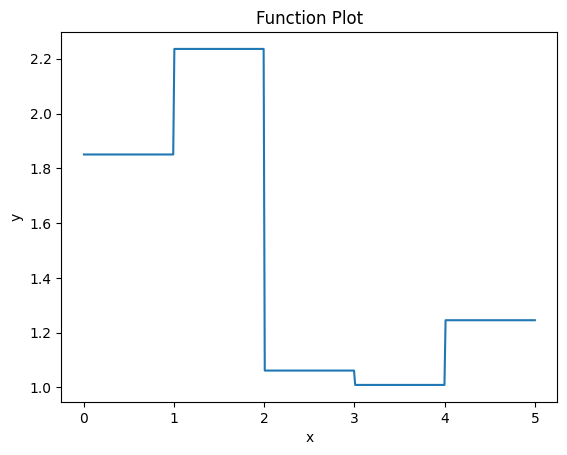

In [5]:
x = np.linspace(time_steps[0], time_steps[-1], 400)

y = [eps_func(x_i) for x_i in x]

plt.plot(x, y)

plt.title('Function Plot')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [6]:
import scope
from scope import model

steps_each_day = 32
steps = (len(time_steps)-1)*steps_each_day
# eps = lambda t: np.exp(0.1 * t) 
eps = eps_func
eps_test = eps
sb_object=model.sb_muti_model(data_lst,time_steps,N_pretraining=4000,N_finetuning=4000,backbone_lr=1e-3,finetuning_lr=1e-3,hiden_size=128,n_layers=4,
                              steps=steps,eps=eps,early_stop=False,patience=32,B=128,lambda_=0,save=True,record_gap=10,save_path='model_history/paul15',
                              prematched=True, label_list=label_list_for_train, edges=final_edges, weighting_strategy='enos', beta=0.9)

INFO: 从演化图中找到了 6 条长度为 6 的有效路径（演化蓝图）。
defaultdict(<class 'float'>, {1: 0.04352916198754603, 2: 0.026206826497131467, 0: 0.2925352836243527, 3: 0.07753680143369417, 4: 0.438802911697242, 5: 0.12138901476003366})


processed: 4000: 100%|██████████| 4000/4000 [28:26<00:00,  2.34it/s, loss=186.3566443711101, loss_fore=185.30751688680053, loss_back=187.40577185541957] 


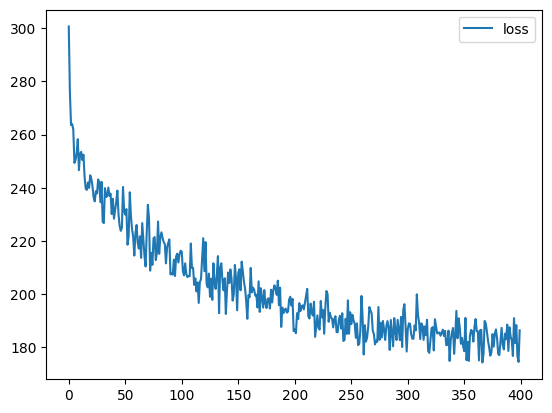

/tmp/ipykernel_490/4262850460.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fore_base=sb_object.eval_fore(torch.tensor(data_lst[0]).repeat(1,1).double(),sb_object.v_fore)


In [7]:
sb_object.backbone_train()
fore_base=sb_object.eval_fore(torch.tensor(data_lst[0]).repeat(1,1).double(),sb_object.v_fore)

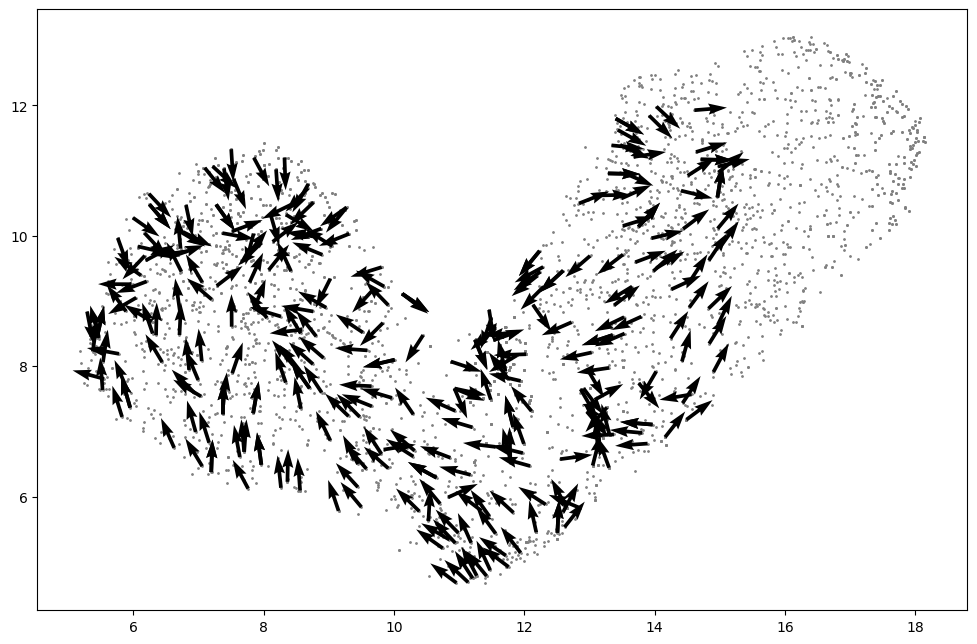

In [8]:
vi.visualize_drift_func([d.cuda() for d in data_lst],np.concatenate(data_lst),sb_object,meta,umap_model=mapper,save_path='./paul15_results/drift_backbone',xg_lower_bound=-15,xg_upper_bound=15,yg_lower_bound=2,yg_upper_bound=12,adjust_equal=True)

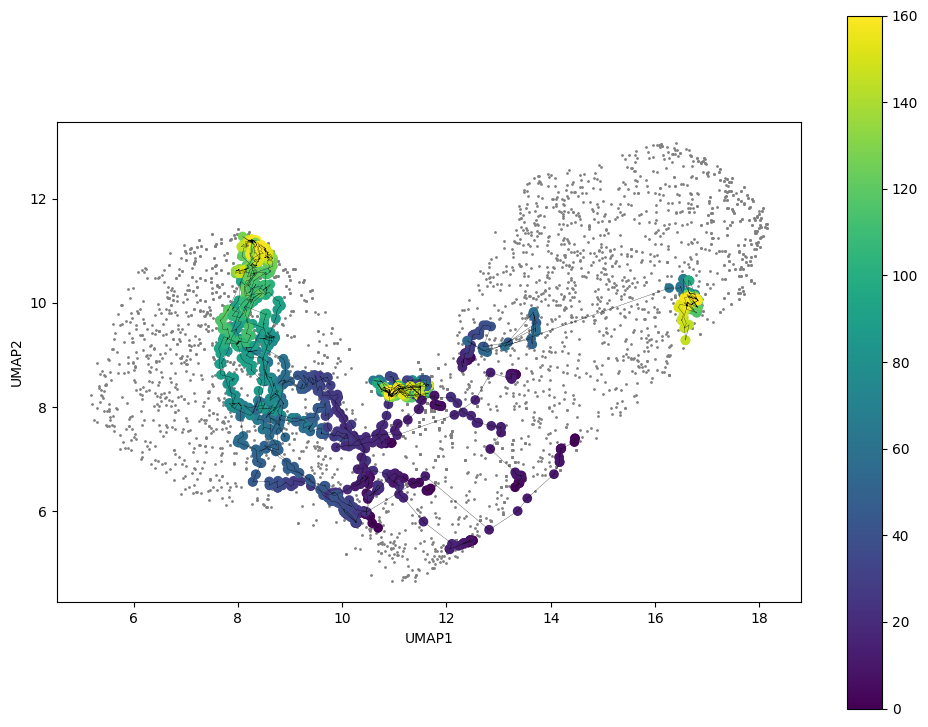

In [9]:
vi.visualize_generated_trajectories(data_lst,fore_base,umap_model=mapper,save_path='./paul15_results/generated_trajectories_backbone',adjust_equal=True,n_trajectories=10)

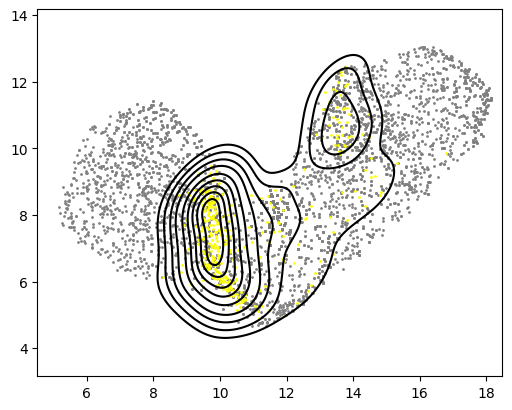

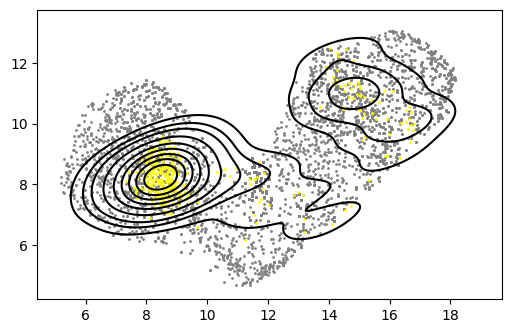

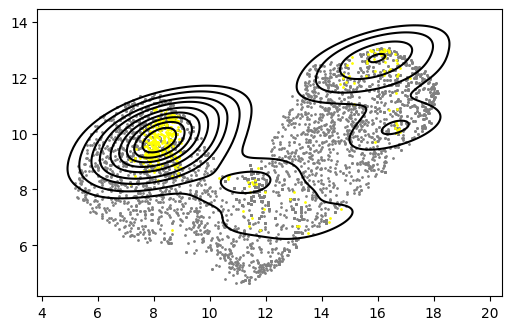

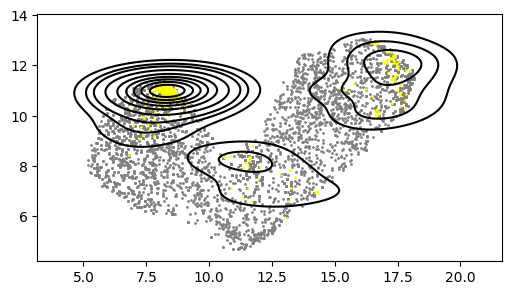

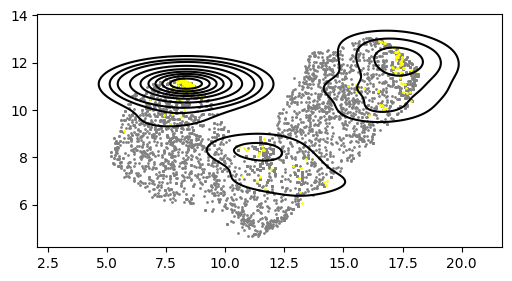

In [10]:
vi.visualize_generated_populations(data_lst,fore_base,time_steps,umap_model=mapper,save_path='./paul15_results/generated_populations_backbone',adjust_equal=True)

In [ ]:
sb_object.fine_tune(change=125)

processed: 287:   7%|▋         | 286/4000 [26:34<5:58:41,  5.79s/it, loss=78.29854816694031, loss_fore=78.29854816694031]  

In [ ]:
fore_ft=sb_object.eval_fore(data_lst[0].double(),sb_object.v_fore_fine_tuned)

In [ ]:
vi.visualize_drift_func([d.cuda() for d in data_lst],np.concatenate(data_lst),sb_object,meta,umap_model=mapper,save_path='./paul15_results/drift_fine_tuned',xg_lower_bound=-15,xg_upper_bound=15,yg_lower_bound=2,yg_upper_bound=12,adjust_equal=True)

In [ ]:
vi.visualize_generated_trajectories(data_lst,fore_ft,umap_model=mapper,save_path='./paul15_results/generated_trajectories_fine_tuned',adjust_equal=True,n_trajectories=10,figsize=(12, 6))

In [ ]:
vi.visualize_generated_populations(data_lst,fore_ft,time_steps,umap_model=mapper,save_path='./paul15_results/generated_populations_fine_tuned',adjust_equal=True)

In [ ]:
from geomloss import SamplesLoss
ot_solver = SamplesLoss("sinkhorn", p = 2, blur = 0.1, scaling = 0.7,backend='auto')

for week,data in enumerate(data_lst[1:]):
    data = torch.tensor(data, dtype=torch.float32).contiguous().cuda()
    back_bone_fake_data = torch.tensor(fore_base[time_steps[week+1]*steps_each_day], dtype=torch.float32).contiguous().cuda()
    print("backbone real" + str(time_steps[week+1]) + "-fake" + str(time_steps[week+1]),ot_solver(data, back_bone_fake_data).item())
    fine_tune_fake_data = torch.tensor(fore_ft[time_steps[week+1]*steps_each_day], dtype=torch.float32).contiguous().cuda()
    print("finetuned real" + str(time_steps[week+1]) + "-fake" + str(time_steps[week+1]),ot_solver(data, fine_tune_fake_data).item())